#**Who Shows Up? Analyzing Attendance Patterns in an Educational Program**

This project analyzes student attendance at workshops on software development, new technologies, and material prototyping for students from sixth to eleventh grade in some schools in Medellín. The project includes a decision tree that predicts which students are more likely to attend the four-session workshop.

## 1. Data transformation and cleaning

In [120]:
#Loading in required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [121]:
#Reading data collect from two educative programs
bd1=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS9IwGj-SwAzPqx6_gNwxigmdziGS0Cgu7-UQqaRp5lyUOs41pkbirF8vIgQxlbsmFMr1nimwC_sHbQ/pub?gid=260434784&single=true&output=csv')
bd2=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSbbYrc301ntoQC-3hdbLjR9UtcBCVpm3fnJrCJSEtQw5-M6bevEnCiCK8L_iWpZLKfklnbHtrXFvR9/pub?gid=0&single=true&output=csv')

In [122]:
#Showing the column names of both dataFrame
bd1.columns,bd2.columns

(Index(['Fecha evento', 'Programa', 'Sede que activa', 'Tipo Doc',
        'N° de Documento', 'Nombres y Apellidos Estudiante', 'Genero',
        'Fecha de Nacimiento', 'Municipio IE', 'Estado Civil',
        'Institucion Educativa', 'Codigo DANE', 'Grado', 'Proveedor',
        'Lugar de Prestacion', 'Tipo de la Experiencia', 'Asistencia'],
       dtype='object'),
 Index(['Fecha evento', 'Programa', 'Sede que activa', 'Tipo Doc',
        'N° de Documento', 'Nombres y Apellidos Estudiante', 'Genero',
        'Fecha de Nacimiento', 'Municipio IE', 'Estado civi',
        'Institución Educativa',
        'Código DANE\n (12 caracteres de la sede principal)', 'Grado',
        'Proveedor', 'Lugar de Prestacion', 'Tipo de la Experiencia',
        'Asistencia'],
       dtype='object'))

In [123]:
#data filtering only for data no related a personal student information
bd1=bd1[['Fecha evento','N° de Documento','Genero','Fecha de Nacimiento','Grado','Asistencia']].copy()
bd2=bd2[['Fecha evento','N° de Documento','Genero','Fecha de Nacimiento','Grado','Asistencia']].copy()


In [124]:
#Merging the two DataFrames into one
df=pd.concat([bd1,bd2], ignore_index=True)


In [125]:
#changing the data type of this columns for datetime
df['Fecha evento']=pd.to_datetime(df['Fecha evento'])
df['Fecha de Nacimiento']=pd.to_datetime(df['Fecha de Nacimiento'],format="mixed")


/tmp/ipython-input-125-3242926677.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Fecha evento']=pd.to_datetime(df['Fecha evento'])


In [126]:
#Calculating the age of the students during the program activities
df['Edad']=df['Fecha evento'].dt.year-df['Fecha de Nacimiento'].dt.year


In [127]:
#Transforming the grade metric into students in grade 9 or higher, and the age metric into students aged 15 or older.

# Function to check if the grade is 9 or higher
def is_grade_9_or_higher(grado):
    try:
        grade_num = int(grado.split('-')[0])
        return grade_num >= 9
    except:
        return False  # Handle cases where the format might be different

# Create the 'Es_grado_9_o_superior' column
df['Es_grado_9_o_superior'] = df['Grado'].apply(is_grade_9_or_higher)

# Create the 'Es_mayor_o_igual_15' column
df['Es_mayor_o_igual_15'] = df['Edad'] >= 15



In [128]:
#Deleting  unnecessary data
df = df.drop(columns=['Fecha evento', 'Fecha de Nacimiento', 'Edad', 'Grado'])


In [129]:
#Create a column called "Event" to track how many workshops each student has attended.
df["Event"] = df.groupby('N° de Documento').cumcount() + 1


In [130]:
# Step 1: Filter only the rows where the student actually attended
attended_df = df[df['Asistencia'] == 'SI']

# Step 2: Get the set of attended events per student
attended_events = attended_df.groupby('N° de Documento')['Event'].apply(set)

# Step 3: Check if the set of attended events contains all 4 events
attended_all_4 = attended_events.apply(lambda x: {1, 2, 3, 4}.issubset(x))

# Step 4: Default to False for students not in the attended_events Series
df['assistance_4_attendance'] = df['N° de Documento'].map(attended_all_4).fillna(False).apply(lambda x: '1' if x else '0')


/tmp/ipython-input-130-1682936612.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['assistance_4_attendance'] = df['N° de Documento'].map(attended_all_4).fillna(False).apply(lambda x: '1' if x else '0')


In [131]:
# Changing Column Names
df.rename(columns={
    'Genero': 'Gender',
    'Asistencia': 'Attendance',
    'Es_grado_9_o_superior': 'Grade_9_or_above',
    'Es_mayor_o_igual_15': 'Age_15_or_older'
}, inplace=True)


In [132]:
# Replacing 'SI' with 1 and 'NO' with 0
df['Attendance'] = df['Attendance'].map({'SI': 1, 'NO': 0})

# Encoding Gender: 'F' → 0, 'M' → 1 (or use OneHotEncoder if needed)
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})


In [133]:
#Group by student and aggregate
agg_df = df.groupby('N° de Documento').agg({
    'Gender': 'first',
    'Grade_9_or_above': 'first',
    'Age_15_or_older': 'first',
    'Attendance': 'sum',
    'assistance_4_attendance': 'first'
}).reset_index()


In [134]:
agg_df = df.drop(columns=['N° de Documento'])
agg_df

,Gender,Attendance,Grade_9_or_above,Age_15_or_older,Event,assistance_4_attendance
0,1,0,False,False,1,0
1,1,0,False,True,1,0
2,0,1,False,False,1,0
3,0,1,False,False,1,1
4,0,1,False,False,1,1
...,...,...,...,...,...,...
2883,0,1,True,True,4,1
2884,0,1,True,True,4,1
2885,0,1,True,True,4,1
2886,1,1,True,True,4,1


##2. Data visualization

### 1. Do Boys and Girls Attend School Equally?

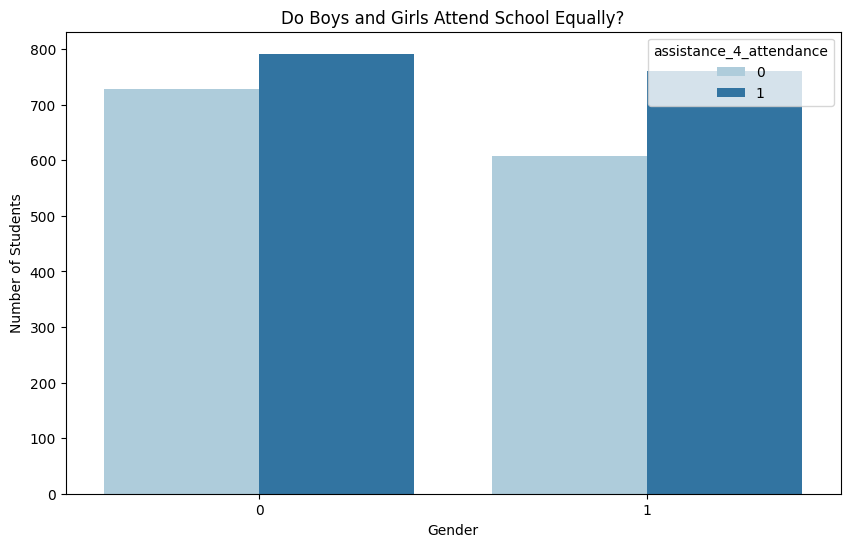

In [135]:

plt.figure(figsize=(10,6));
sns.countplot(data=agg_df,x='Gender', hue='assistance_4_attendance',palette='Paired')
plt.title('Do Boys and Girls Attend School Equally?')
plt.ylabel('Number of Students')
plt.xlabel('Gender')
plt.show()


In [136]:
# Displaying relative percentage (row-wise) of assistance by gender
pd.crosstab(index=agg_df['assistance_4_attendance'],
            columns=df['Gender'],
            normalize='index',
            margins=True).round(4) * 100


Gender,0,1
assistance_4_attendance,,
0,54.49,45.51
1,51.03,48.97
All,52.63,47.37


In general, there is not a significant difference in attendance between boys and girls, with girls making up 51% of attendees, compared to 48.9% for boys. However, girls had the highest rate of non-attendance, at 54%, compared to 45% for boys.

### 2. Does Moving to Higher Grades Affect Attendance?”

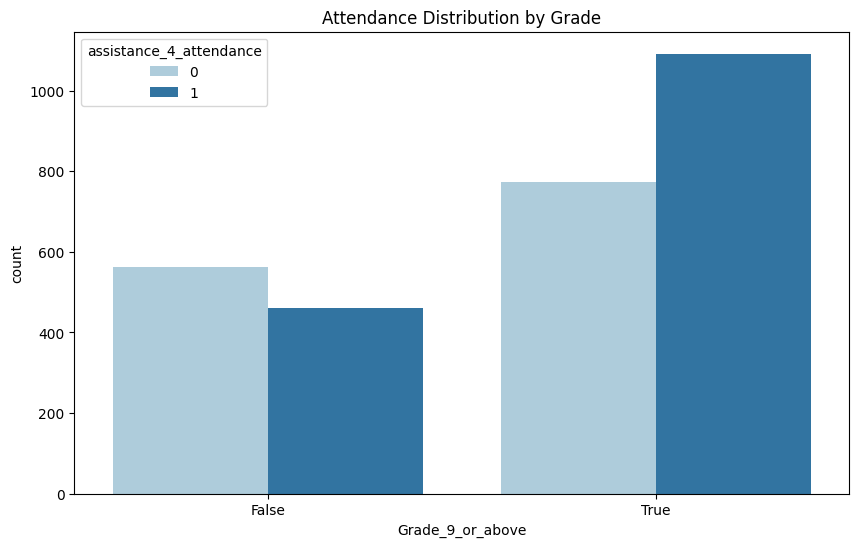

In [137]:
#Attendance Distribution by grade
plt.figure(figsize=(10,6));
plot=sns.countplot(data = df, x = "Grade_9_or_above", hue = 'assistance_4_attendance', palette='Paired');
plt.title('Attendance Distribution by Grade')
plt.show()

In [138]:
# Showing the proportion of total students by grade level and attendance.
pd.crosstab(index=df['Grade_9_or_above'], columns=df['assistance_4_attendance'],margins=True).apply(lambda r:(r/len(df))*100)

assistance_4_attendance,0,1,All
Grade_9_or_above,,,
False,19.459834,15.927978,35.387812
True,26.800554,37.811634,64.612188
All,46.260388,53.739612,100.000000


Attendance is higher among students in Grade 9 or above: 37.81% of students in this group attended, compared to 15.93% for those below Grade 9.

### 3. Is Age 15 a Turning Point for Attendance?

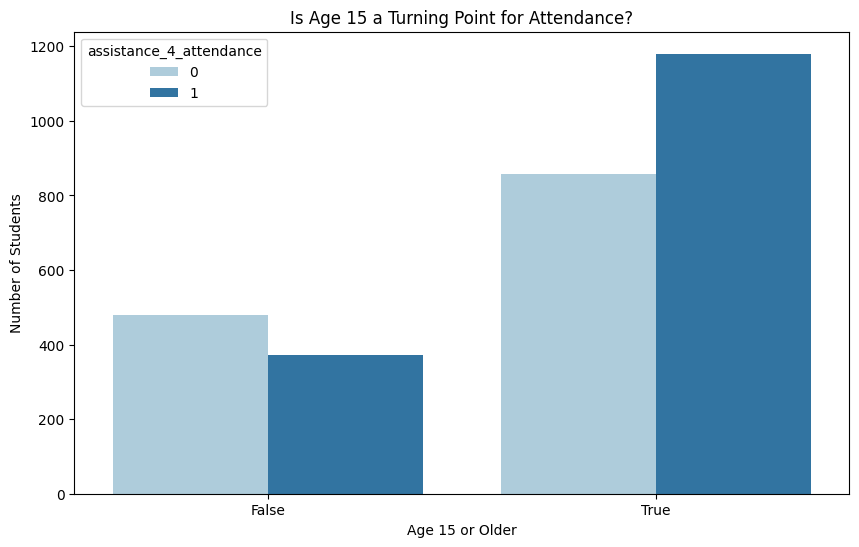

In [139]:
plt.figure(figsize=(10,6));
sns.countplot(x='Age_15_or_older', hue='assistance_4_attendance', data=df,palette='Paired')
plt.title('Is Age 15 a Turning Point for Attendance?')
plt.xlabel('Age 15 or Older')
plt.ylabel('Number of Students')
plt.show()


In [140]:
# Displaying total assistance by gender.
pd.crosstab(index=df['assistance_4_attendance'], columns=df['Age_15_or_older'],margins=True)

Age_15_or_older,False,True,All
assistance_4_attendance,,,
0,479,857,1336
1,372,1180,1552
All,851,2037,2888


Yes, it is. Age is a turning point for attendance, with 1,187 of the students who attended the four sessions being older than 15 years old, compared to 372 who were younger than 15.

### 4. When Age and Grade Combine: What Happens to Attendance?

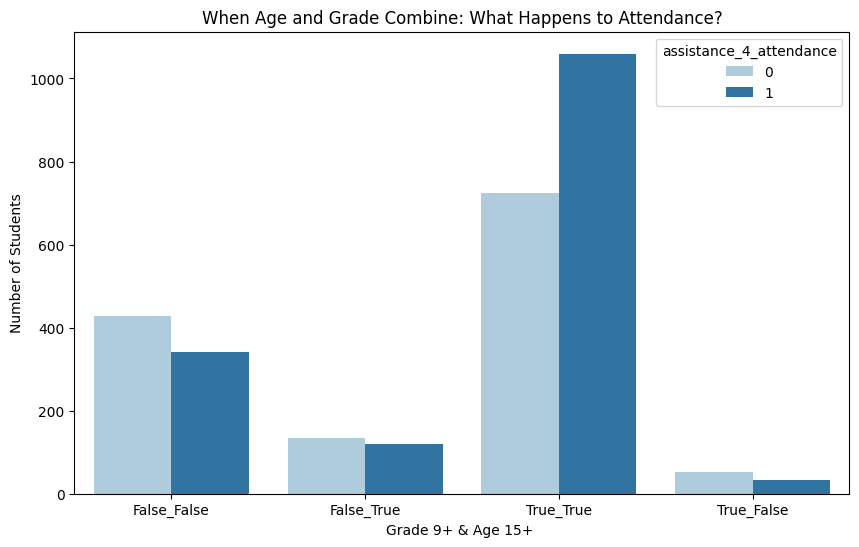

In [141]:
plt.figure(figsize=(10,6));
agg_df['Group'] = agg_df['Grade_9_or_above'].astype(str) + '_' + agg_df['Age_15_or_older'].astype(str)
sns.countplot(x='Group', hue='assistance_4_attendance', data=agg_df, palette='Paired')
plt.title('When Age and Grade Combine: What Happens to Attendance?')
plt.xlabel('Grade 9+ & Age 15+ ')
plt.ylabel('Number of Students')
plt.show()


Students who are both in Grade 9 or above and aged 15+ show the highest attendance rates, suggesting that academic progression aligned with age significantly boosts participation. In contrast, students with mismatched age and grade levels attend less. However, this analysis does not consider whether the type of workshops offered may have been less appealing or relevant to younger students in lower grades, which could also influence attendance.










#3. Data modeling

### Who is more likely to attend the four-session workshop?

articipants most likely to attend the full four-session workshop are those older than 15 years and who reached event sessions beyond the third one, showing an attendance rate of 83.5%. Notably, even younger students demonstrate high participation (79.1%) in later sessions, suggesting increased engagement as the workshop progresses.

In [143]:
#Loading more required libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [148]:
#Eliminating unnecessary data

df=df.drop(['N° de Documento'], axis=1)

In [149]:
# Features (X) and target (y)
y=df["assistance_4_attendance"].dropna()
X=df.drop(["assistance_4_attendance"], axis=1)

In [150]:
y.value_counts()

,count
assistance_4_attendance,
1,1552
0,1336


In [151]:
# Split the data in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [152]:
#Balance data

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [153]:
#Applying a decision tree model

clasificacion = DecisionTreeClassifier(max_depth=3, random_state=42)
clasificacion.fit(X_train_bal, y_train_bal)


DecisionTreeClassifier(max_depth=3, random_state=42)

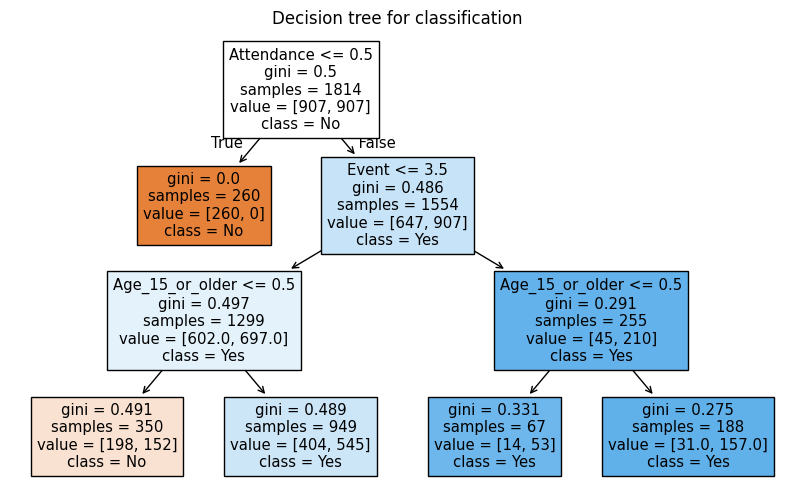

In [156]:
plt.figure(figsize=(10,6))
plot_tree(clasificacion, feature_names=X.columns.tolist(), class_names=['No', 'Yes'], filled=True)
plt.title("Decision tree for classification")
plt.show()

### Model Performance

The project includes a decision tree that predicts which students are more likely to attend the four-session workshop. The model achieved an accuracy of 66.3%, performing significantly better at identifying students who completed the workshop (recall = 0.80) than those who did not (recall = 0.49). This makes the model useful for targeting likely participants, though there's room for improvement in recognizing potential dropouts.

In [154]:
y_pred = clasificacion.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.6634948096885813
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.66      0.49      0.56       511
           1       0.66      0.80      0.73       645

    accuracy                           0.66      1156
   macro avg       0.66      0.65      0.64      1156
weighted avg       0.66      0.66      0.65      1156

